In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
    
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]
print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [3]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_14912\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_14912\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

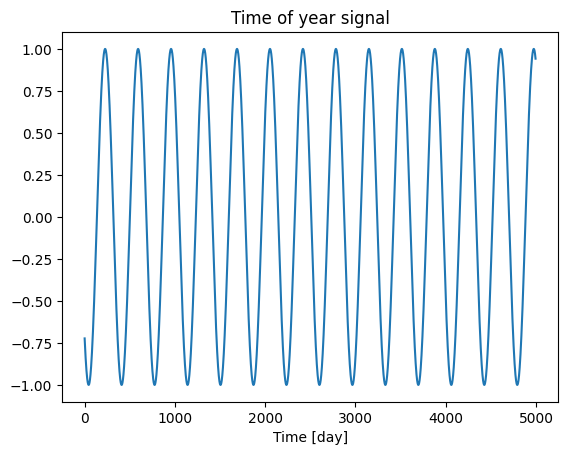

In [4]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

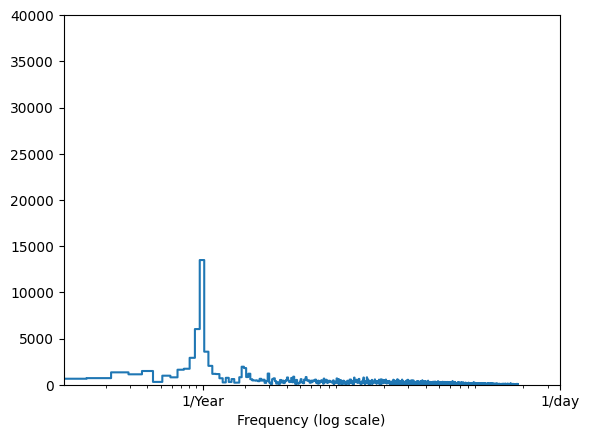

In [5]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [7]:
def create_data(in_steps, out_steps, data, features):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][features])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [11]:
in_steps = 60
out_steps = 14
features_train = ['humidity']
num_features = len(features_train) 

In [13]:
X_train, y_train = create_data(in_steps, out_steps, train, features_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], num_features)

X_test, y_test = create_data(in_steps, out_steps, test, features_train)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], num_features)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)


(3922, 60, 10) (3922, 14, 1) (926, 60, 10) (926, 14, 1)


In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(out_steps*2),
    tf.keras.layers.Reshape([out_steps, 2])
])



In [19]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Lion(learning_rate = 0.001),
)

In [20]:
history = model.fit(X_train_norm, y_train_norm, epochs=4, validation_split=0.2, batch_size=32, validation_batch_size=32)

Epoch 1/4
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.9446 - val_loss: 1.0414
Epoch 2/4
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.8766 - val_loss: 1.0077
Epoch 3/4
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.8073 - val_loss: 0.9089
Epoch 4/4
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.8168 - val_loss: 0.9362


In [21]:
model.save('lstm60-humidity-not_overfit.keras')

In [22]:
model_recall = tf.keras.models.load_model('lstm60-humidity-not_overfit.keras')

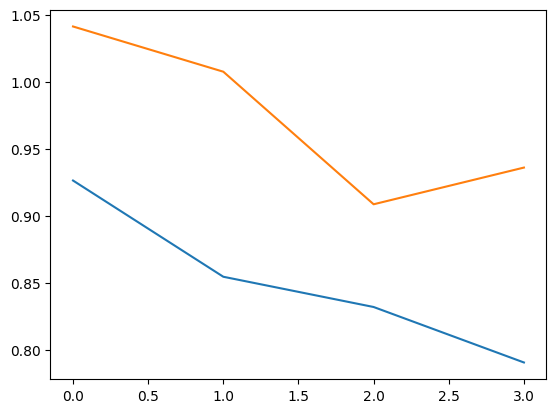

In [23]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])

In [24]:
print(model_recall.evaluate(X_test_norm, y_test_norm))
print(model.evaluate(X_test_norm, y_test_norm))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0691
1.0858700275421143
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0691
1.0858700275421143


In [15]:
predict = model_recall.predict(X_test_norm)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[[-0.83663285  1.0971767 ]
  [-0.88170886  1.2178735 ]
  [-0.8724627   1.2634399 ]
  [-0.8354455   1.2482101 ]
  [-0.775368    1.1348234 ]
  [-0.7321922   0.91663766]
  [-0.7478556   0.64469445]
  [-0.8298349   0.80879664]
  [-0.8921313   1.1872072 ]
  [-0.91452134  1.4620261 ]
  [-0.91450346  1.4812422 ]
  [-0.85520923  1.2911819 ]
  [-0.8253617   1.204228  ]
  [-0.82799935  1.4067725 ]]

 [[-0.81609786  1.2727137 ]
  [-0.8424913   1.3046204 ]
  [-0.83101636  1.1838765 ]
  [-0.7898593   1.0372341 ]
  [-0.75679064  0.8335878 ]
  [-0.73743886  0.7199221 ]
  [-0.7827101   0.81030834]
  [-0.88901544  1.249978  ]
  [-0.9249544   1.5614979 ]
  [-0.9212768   1.5012882 ]
  [-0.8861186   1.2202814 ]
  [-0.8335961   1.2806375 ]
  [-0.8161711   1.5149381 ]
  [-0.8099362   1.5270458 ]]

 [[-0.824562    1.3314393 ]
  [-0.8317768   1.3721353 ]
  [-0.7760167   0.95678246]
  [-0.7292737   0.6398096 ]
  [-0.7443561   0.7328374 ]
  [-0.77071834  0.9169338 ]
  [-

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Day:  1
MAE:  6.914238821404541
MSE:  82.01009176690054
CORR:  0.540261965819348
Day:  2
MAE:  7.731607300364947
MSE:  100.7605623268129
CORR:  0.37774085867391516
Day:  3
MAE:  8.33160331511858
MSE:  112.53483397016343
CORR:  0.2494751485470272
Day:  4
MAE:  8.485083452723195
MSE:  117.4019878325085
CORR:  0.17547396888770325
Day:  5
MAE:  8.538661669242975
MSE:  119.33140536909869
CORR:  0.1372300662744036
Day:  6
MAE:  8.655491536842824
MSE:  122.85035379919103
CORR:  0.08750377400586123
Day:  7
MAE:  8.641716174790977
MSE:  122.92905148100128
CORR:  0.053782440936496485
Day:  8
MAE:  8.966723231568965
MSE:  130.52198702096808
CORR:  -0.005309936493911849
Day:  9
MAE:  8.763590719169468
MSE:  126.24744136195793
CORR:  0.01926989681508784
Day:  10
MAE:  8.656983511906205
MSE:  124.00757453035686
CORR:  0.03632995294147873
Day:  11
MAE:  8.6489507638095
MSE:  122.34368391147262
CORR:  0.06354385629995947
Day:  12
MAE:  8.926174088842668
MSE:  12

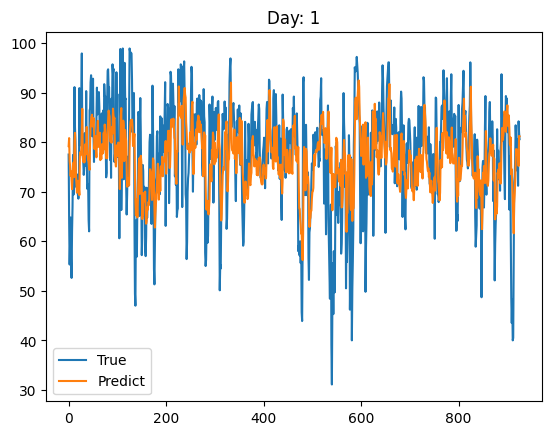

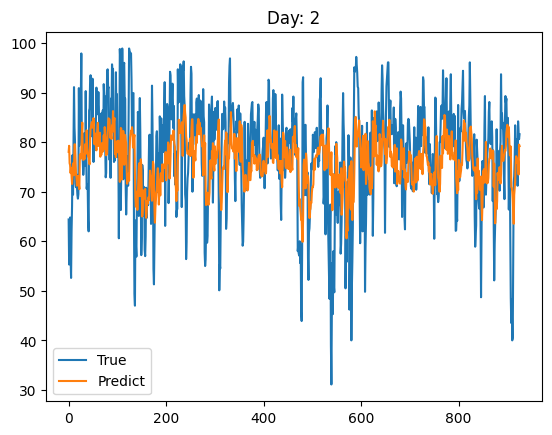

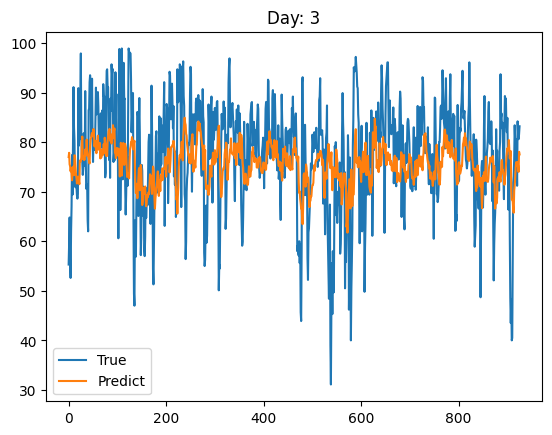

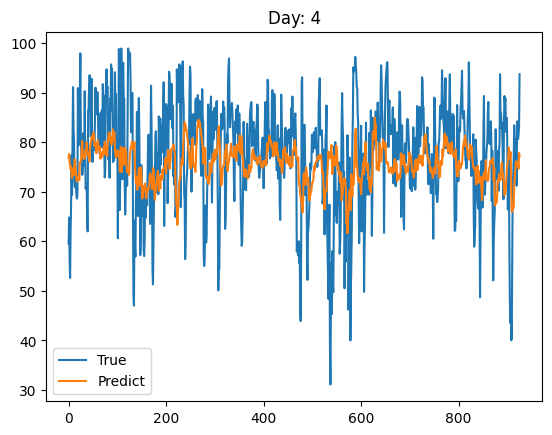

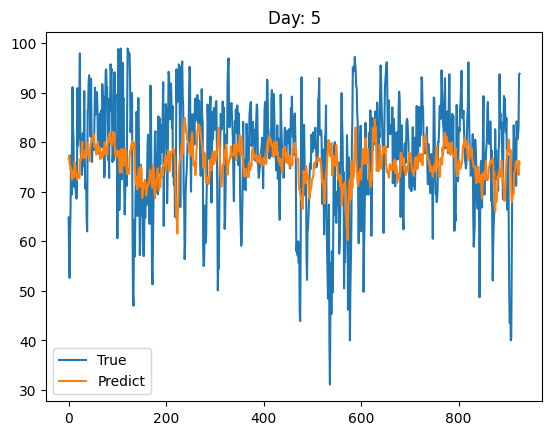

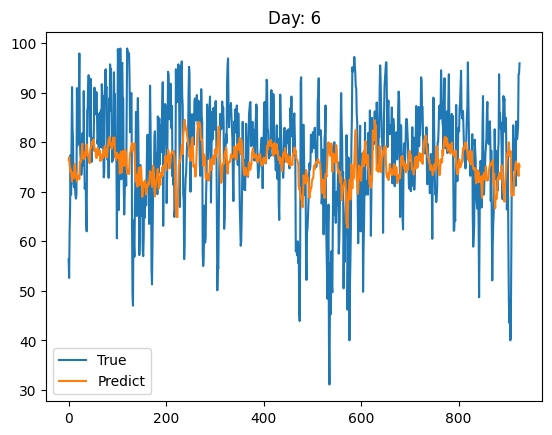

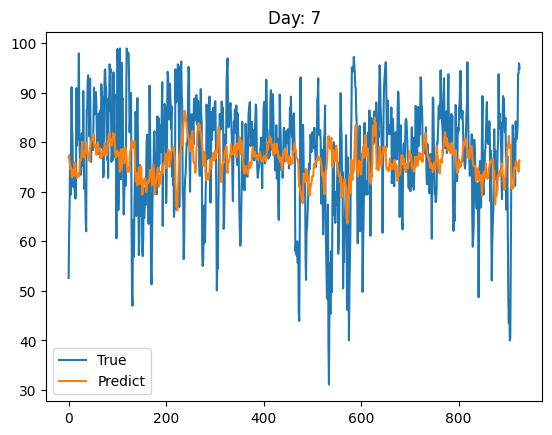

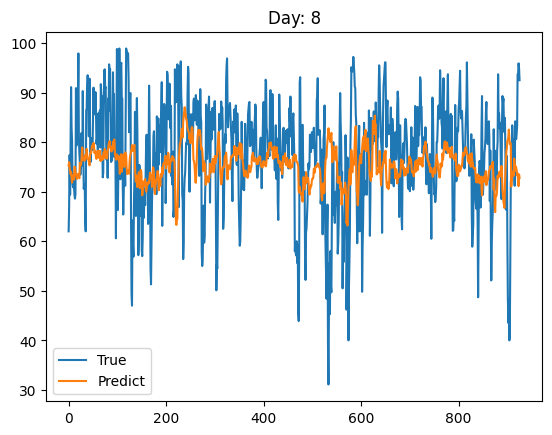

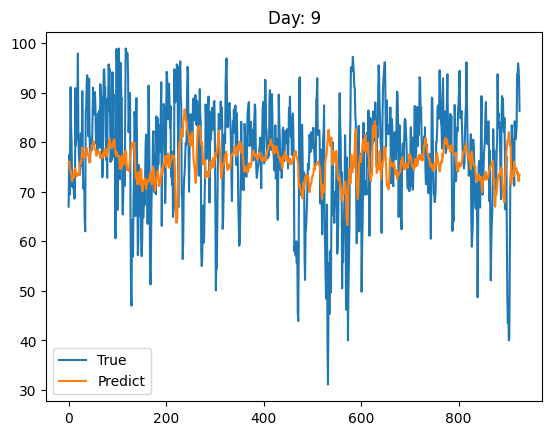

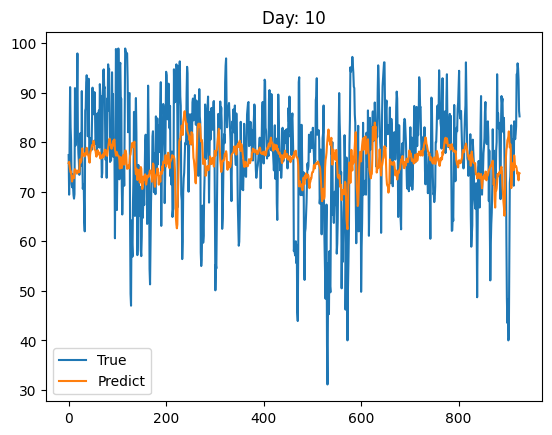

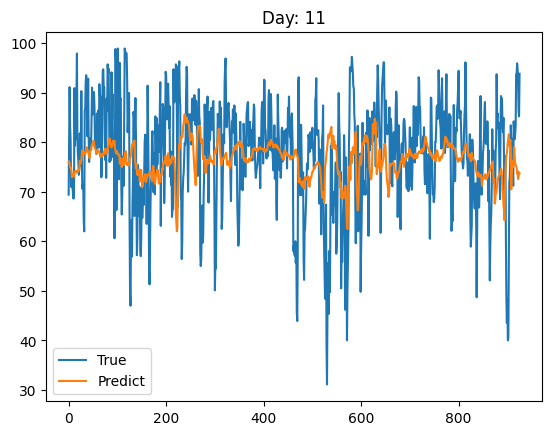

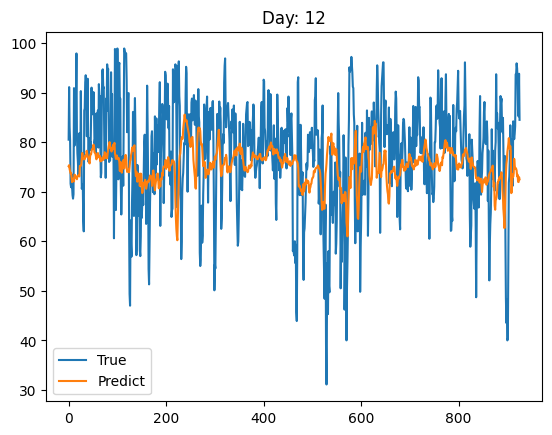

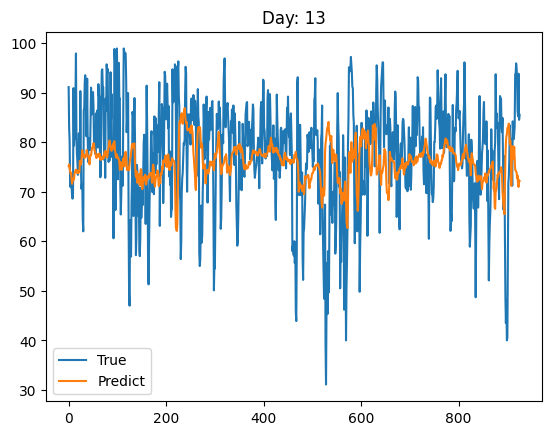

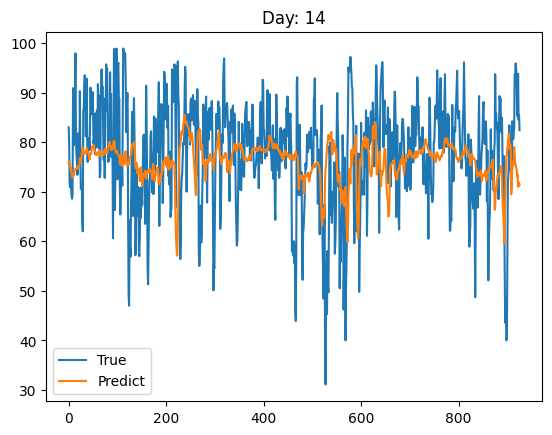

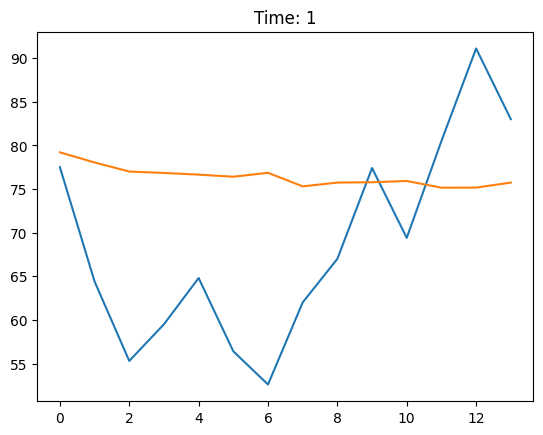

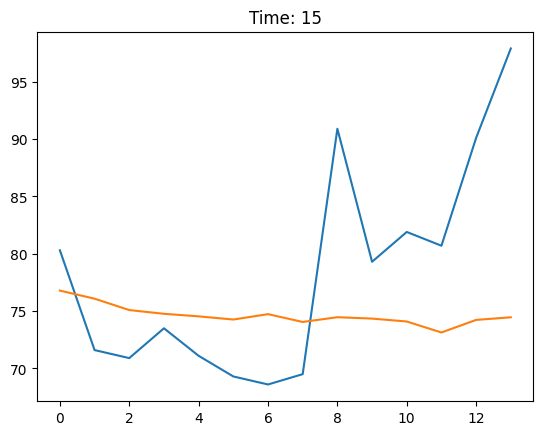

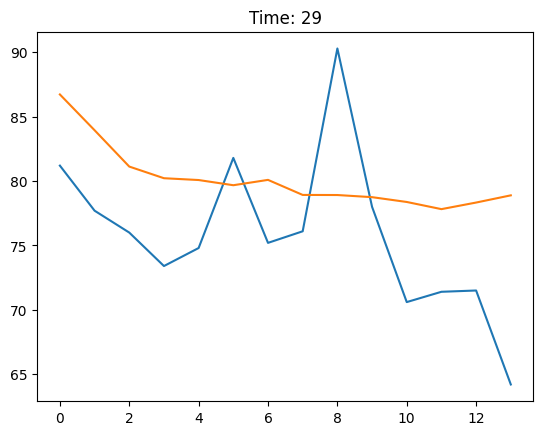

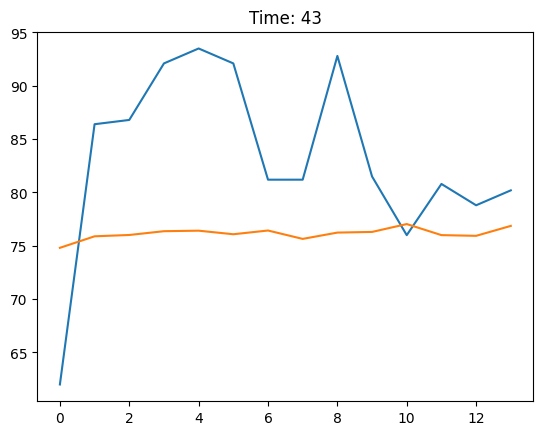

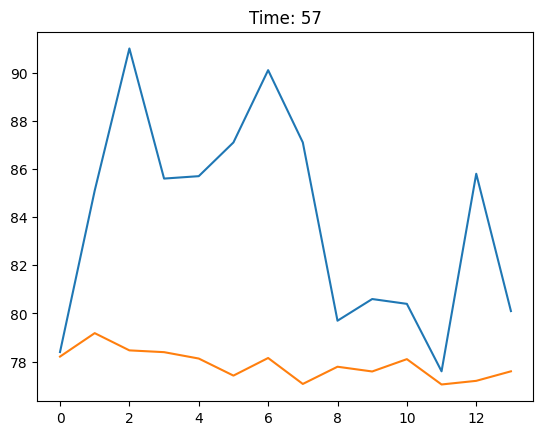

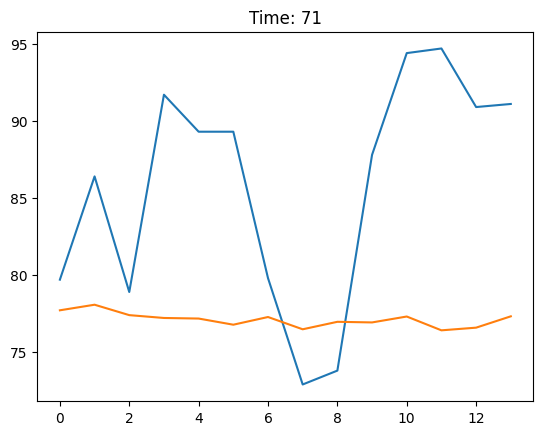

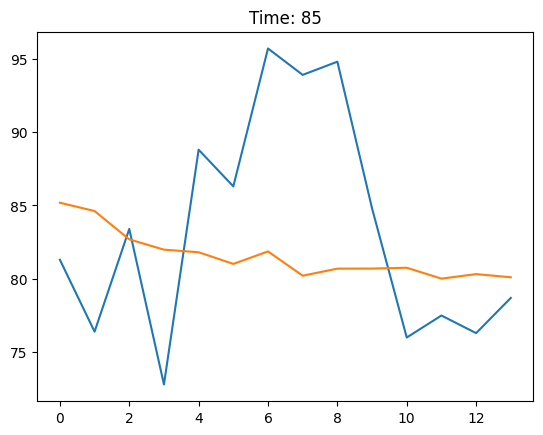

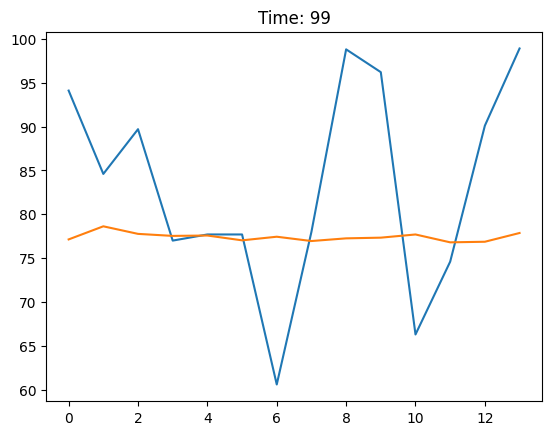

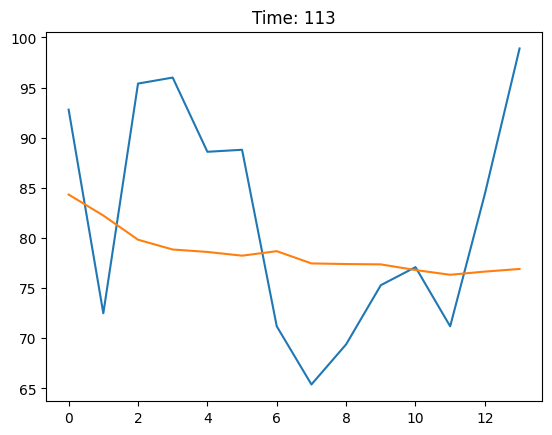

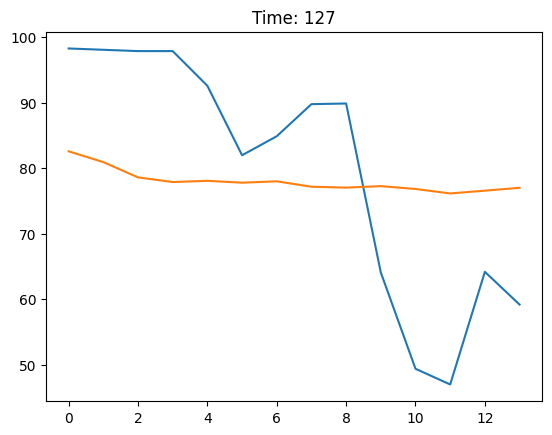

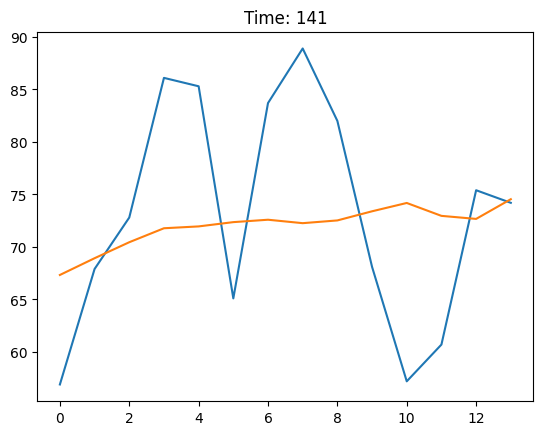

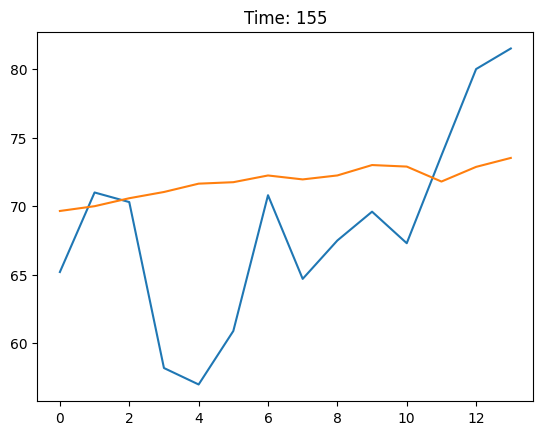

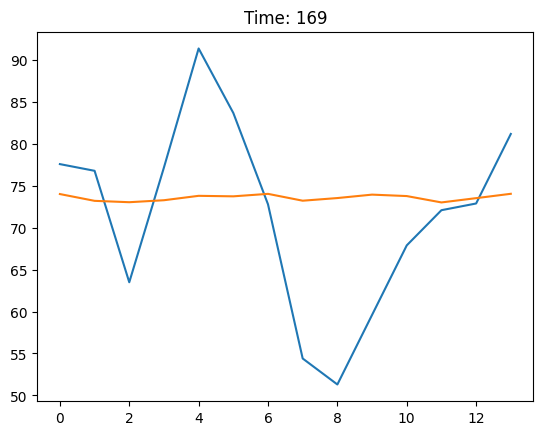

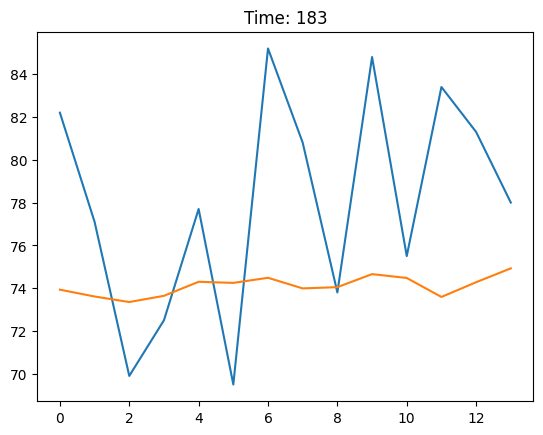

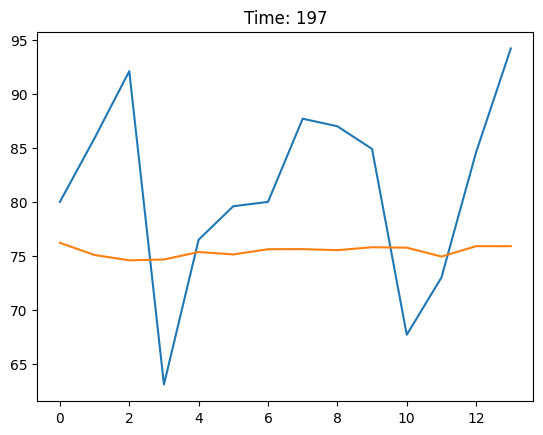

In [25]:
predict = model_recall.predict(X_test_norm)
feature = 0
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,feature])
    plt.plot(predict_unnorm[:,i,feature])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,feature])
    plt.plot(predict_unnorm[i,:,feature])
    plt.show()
    

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Day:  1
MAE:  1.3200931738571264
MSE:  2.9944188617498853
CORR:  0.9440760708713581
Day:  2
MAE:  1.8616499952312162
MSE:  5.865879872906239
CORR:  0.8933207378623046
Day:  3
MAE:  2.080636138586452
MSE:  7.069395510079259
CORR:  0.8627883793001669
Day:  4
MAE:  2.178124104823201
MSE:  7.626521770683228
CORR:  0.8466321885797321
Day:  5
MAE:  2.3640130930791408
MSE:  9.030768526628941
CORR:  0.8317696381565003
Day:  6
MAE:  2.3539406288262317
MSE:  8.933581783082342
CORR:  0.8260062239835475
Day:  7
MAE:  2.3565068852566746
MSE:  9.003172630568642
CORR:  0.8224517386412187
Day:  8
MAE:  2.446172292392146
MSE:  9.61203276515773
CORR:  0.8136531358592547
Day:  9
MAE:  2.5459079565291267
MSE:  10.516593099357928
CORR:  0.8114505896986448
Day:  10
MAE:  2.452378145304406
MSE:  9.578242348755852
CORR:  0.8121335366350768
Day:  11
MAE:  2.658905454433762
MSE:  11.384172524066507
CORR:  0.8096647483615422
Day:  12
MAE:  2.715023728735246
MSE:  11.804504

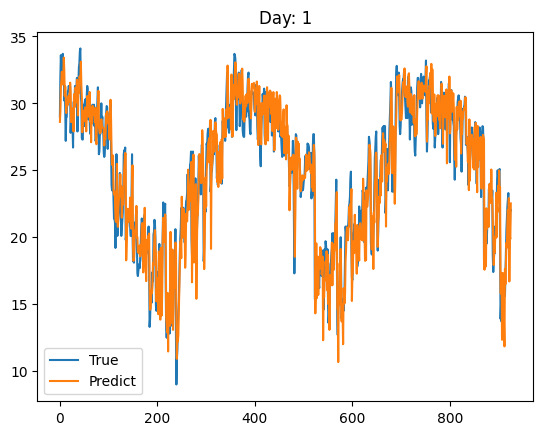

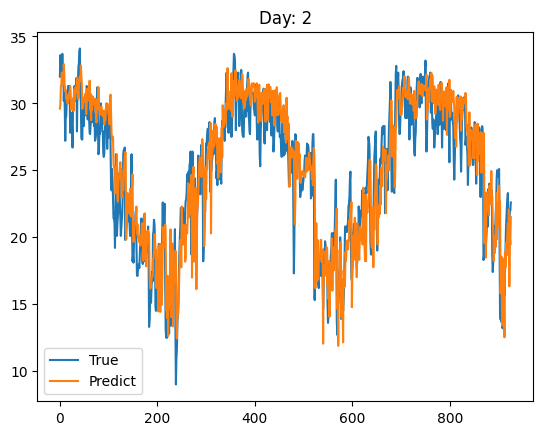

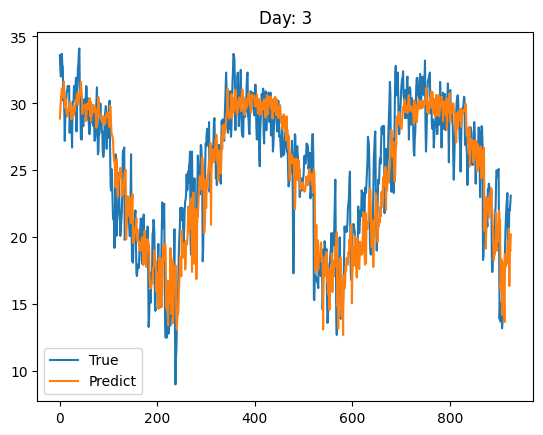

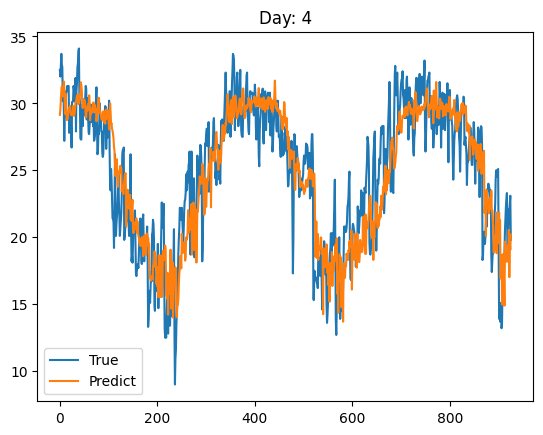

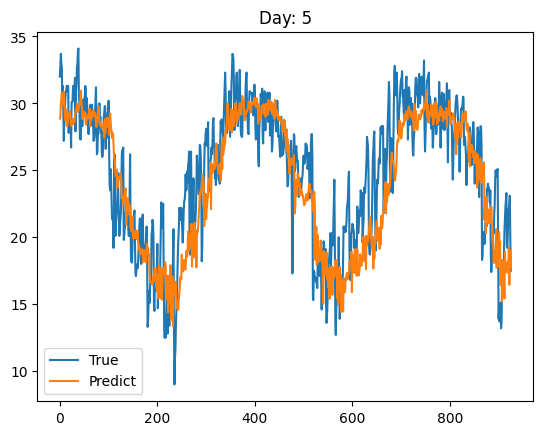

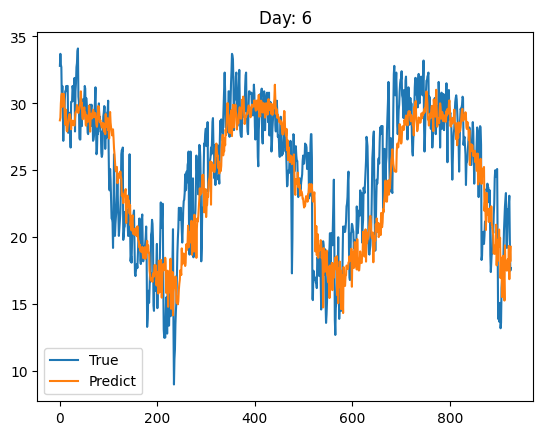

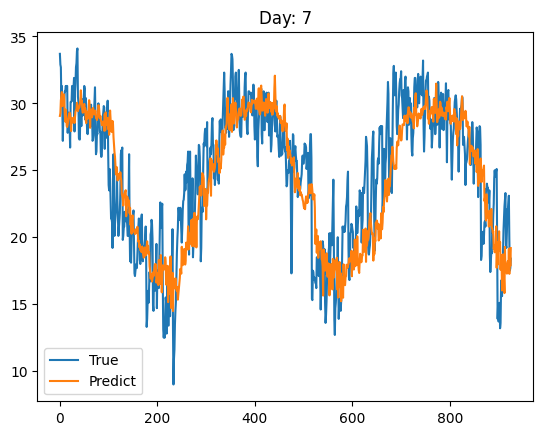

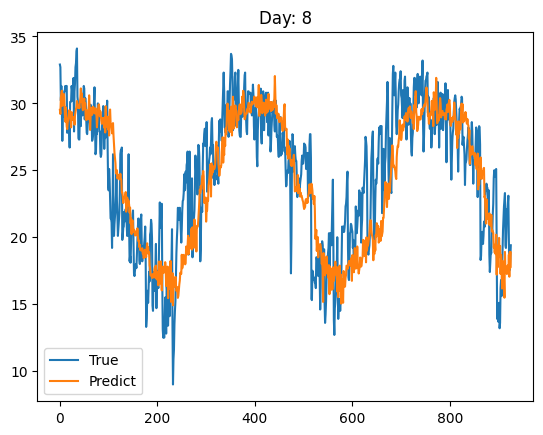

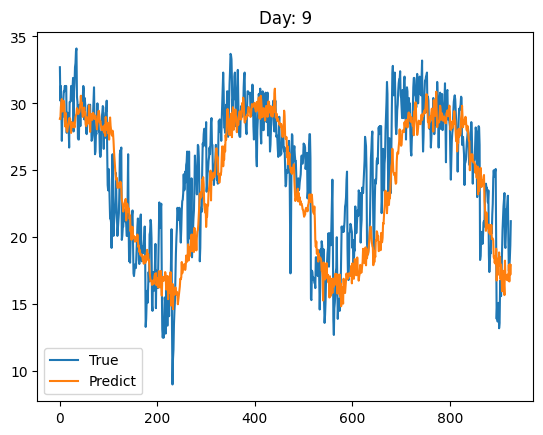

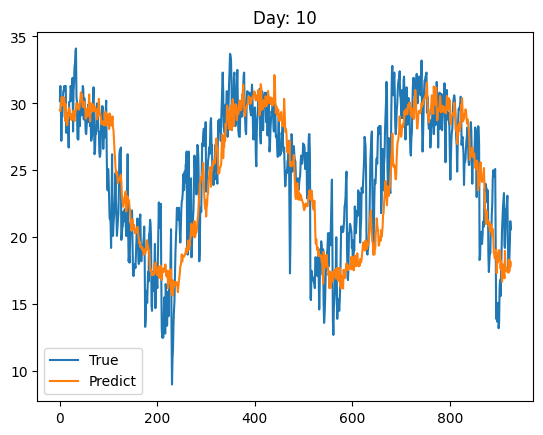

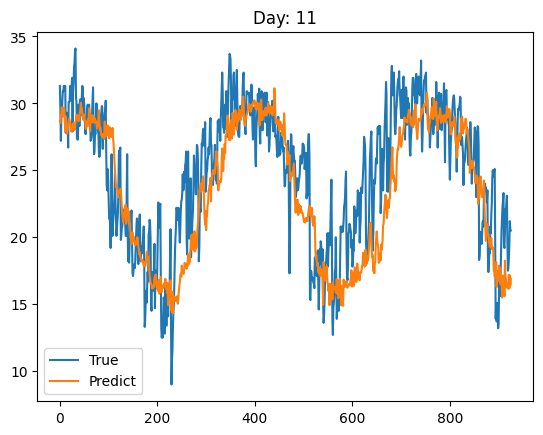

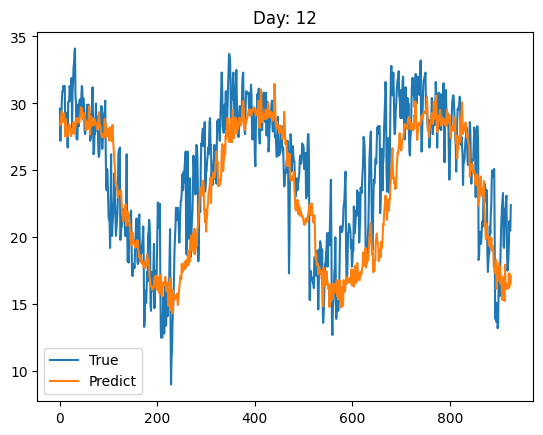

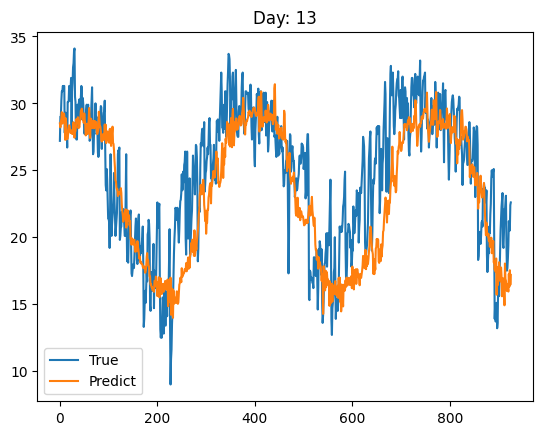

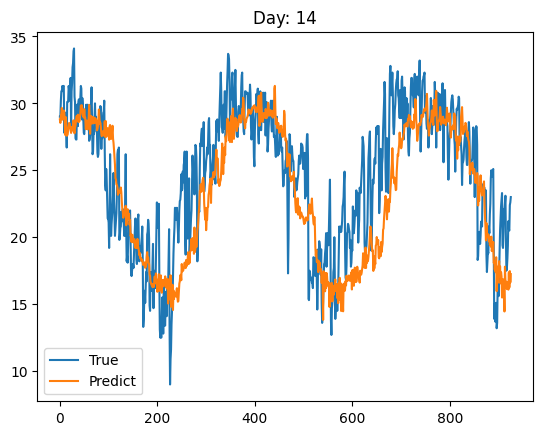

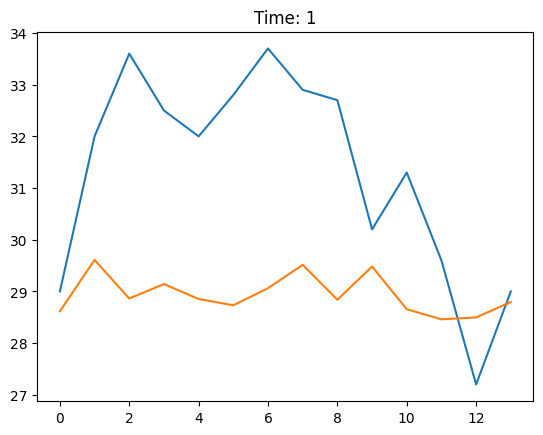

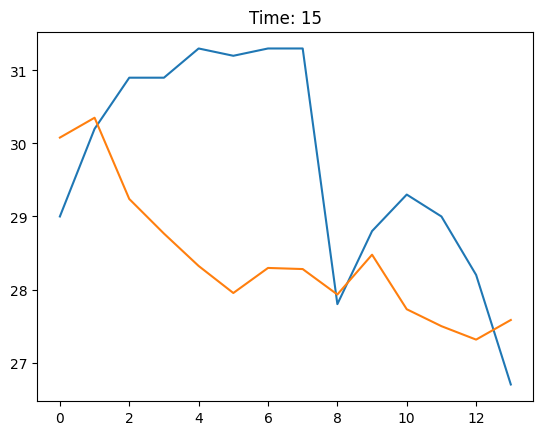

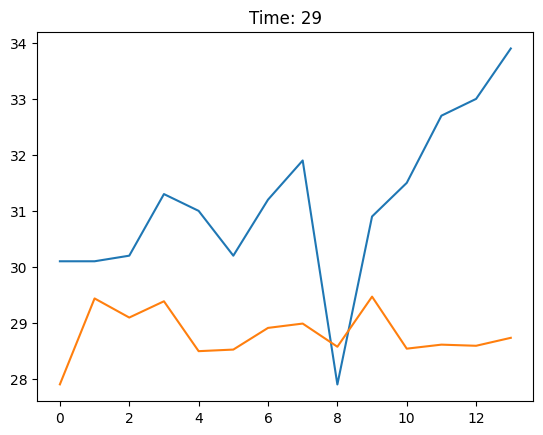

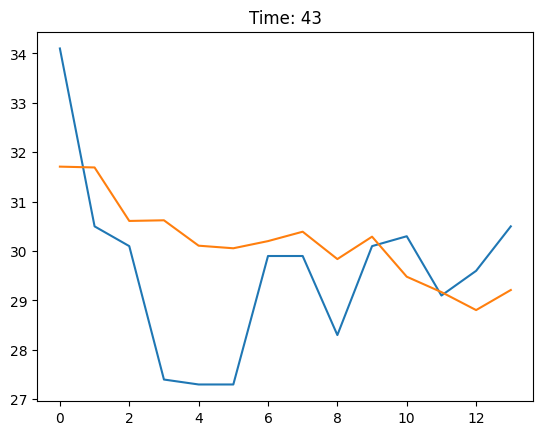

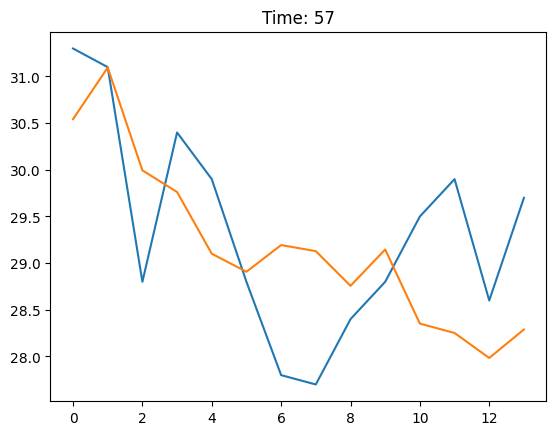

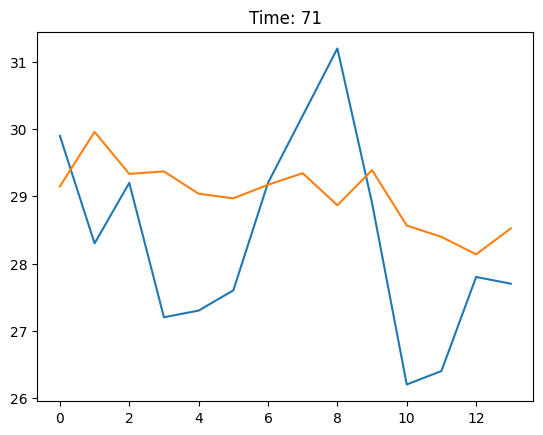

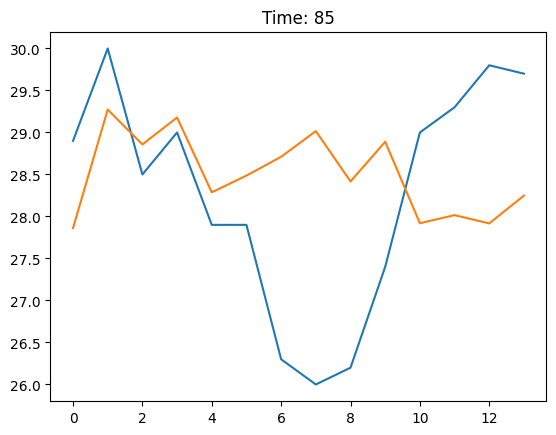

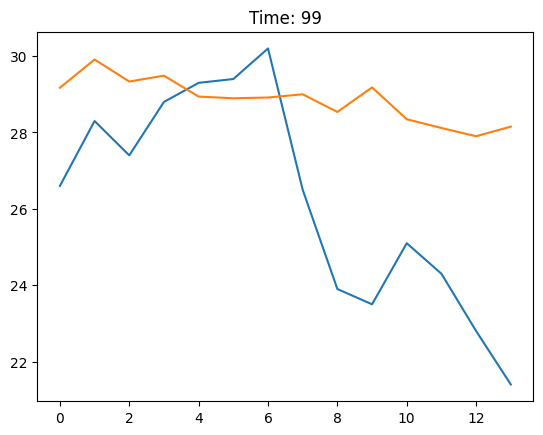

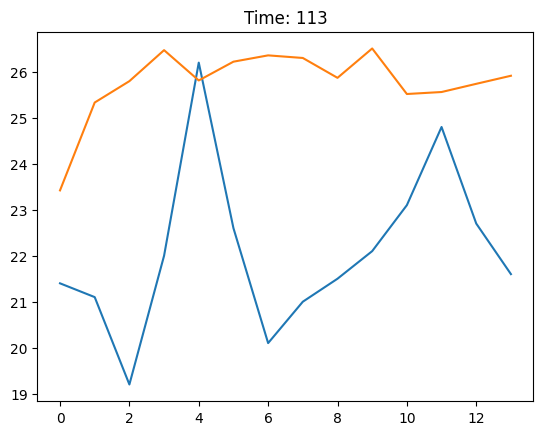

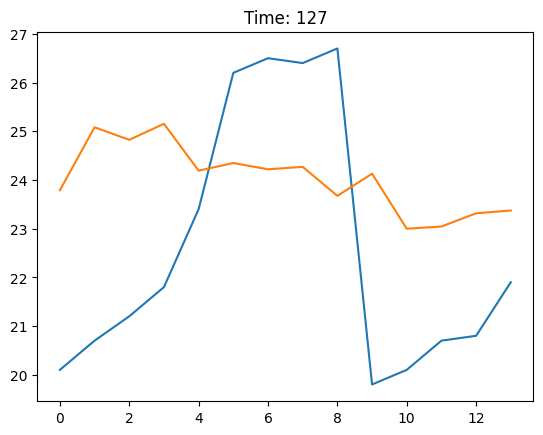

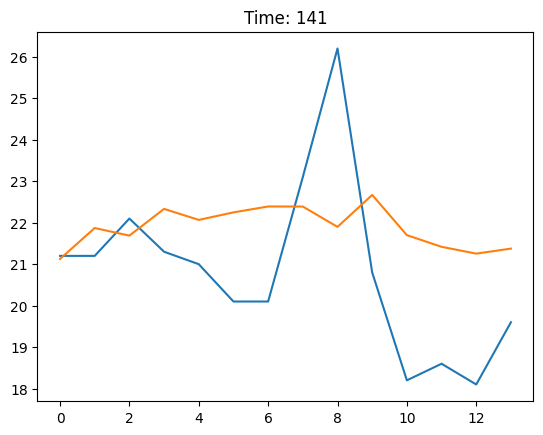

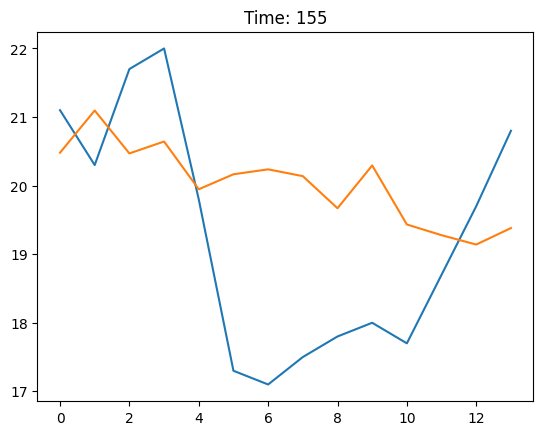

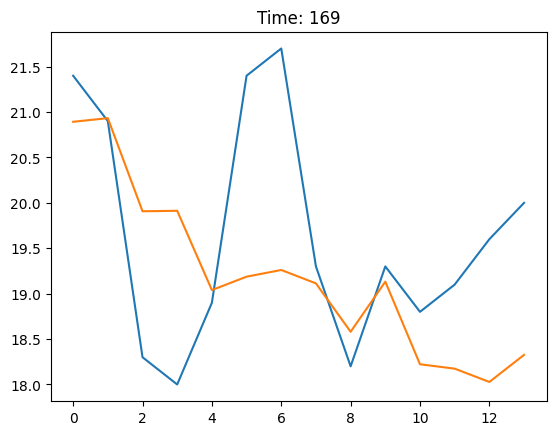

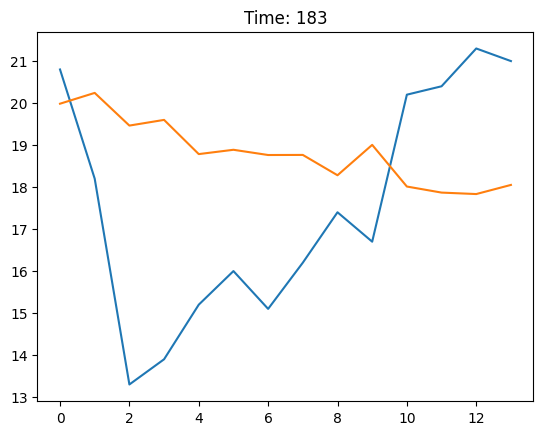

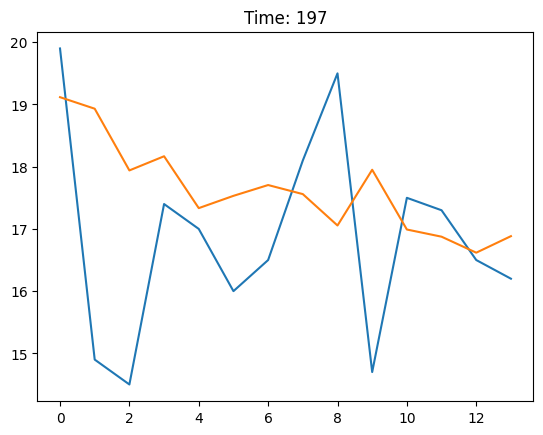

In [54]:
predict = model.predict(X_test_norm)
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,0], predict_unnorm[:,i,0])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,0])
    plt.plot(predict_unnorm[:,i,0])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,0])
    plt.plot(predict_unnorm[i,:,0])
    plt.show()